# Full Stack Data Delivery

In my journey to understand data stewardship from end to end, I still have a lot to learn.

The purpose of this project is not to claim perfect knowledge of all systems; it is to demonstrate my ability to abstract data design systems and write portable and modular code.


When I re-hashed the dunnhumby project in Feb 2022, I had just learned the basics of Python class structures and inheritance. 

In 1.5 years since then, I've had the chance to apply my coding expertise to real-world data systems, and have a better idea of what is required from a data team.


The goal of this project is to deliver actionable and informative data insights from raw data;
     
    Extraction
    - Control the flow of data from a raw data source into a database

    Transforms 
    - create highly available 'action' tables through data Transformations
        - 'customer profile' analytics summary
        - product recommendations based on previous purchases
    
    Loading
    - create API endpoints which allow access to the insights
    - deliver business insights and visualizations with `streamlit`, a browser-based frontend application sponsored by 80% of fortune 50 companies

### INGESTING DATA (EXTRACT)

In [4]:
import pandas as pd
from dunnhumby_data_warehouse import DunnHumbyDataWarehouse, engine

# DataLake is 

print(engine.table_names())

a = DunnHumbyDataWarehouse()

# prints existing database rowcounts on init.. 

# currently no cache/log of previous data source index values with which to 
# compare data source -> data lake rowcount check...data must be loaded to memory in order to find data source index

2023-10-30 10:36:23,362 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2023-10-30 10:36:23,363 INFO sqlalchemy.engine.Engine [raw sql] ()
['campaign_desc', 'campaign_table', 'causal_data', 'coupon', 'coupon_redempt', 'hh_demographic', 'hh_summary', 'product', 'transaction_data']
2023-10-30 10:36:23,364 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2023-10-30 10:36:23,365 INFO sqlalchemy.engine.Engine [raw sql] ()


C:\Users\polan\AppData\Local\Temp\ipykernel_9524\448393142.py:6: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  print(engine.table_names())


{'campaign_desc': 30,
 'campaign_table': 7208,
 'causal_data': 36786524,
 'coupon': 124548,
 'coupon_redempt': 2318,
 'hh_demographic': 801,
 'hh_summary': 801,
 'product': 92353,
 'transaction_data': 2595732}


The rowcounts above match my previous EDA with this dataset using Python. 

Note that the summary analytics table `hh_summary` is a derived table.

In the next section, we're going to use this raw data/data lake to generate some new tables which will promote availability in the API. 

## TRANSFORMS

Whatever method of data ingestion that we use (events, etc.), we now have all the data extracted into our database. We could add event hooks in our front-end to populate new tables, should that be appropriate.

#### Availability

Data availability is the idea that some automated or triggered functions can be used to transform data ahead of time, and have it ready for the customer or user.

In practice, this looks like scheduled tasks which populate new tables, or update existing ones. 

In this sort of workflow, we might add several new tables to record metadata such as 'last updated on'; etc., as well as to provide a summary of analytics.



![DunnHumby API Design-2023-10-27-1224.png](<attachment:DunnHumby API Design-2023-10-27-1224.png>)
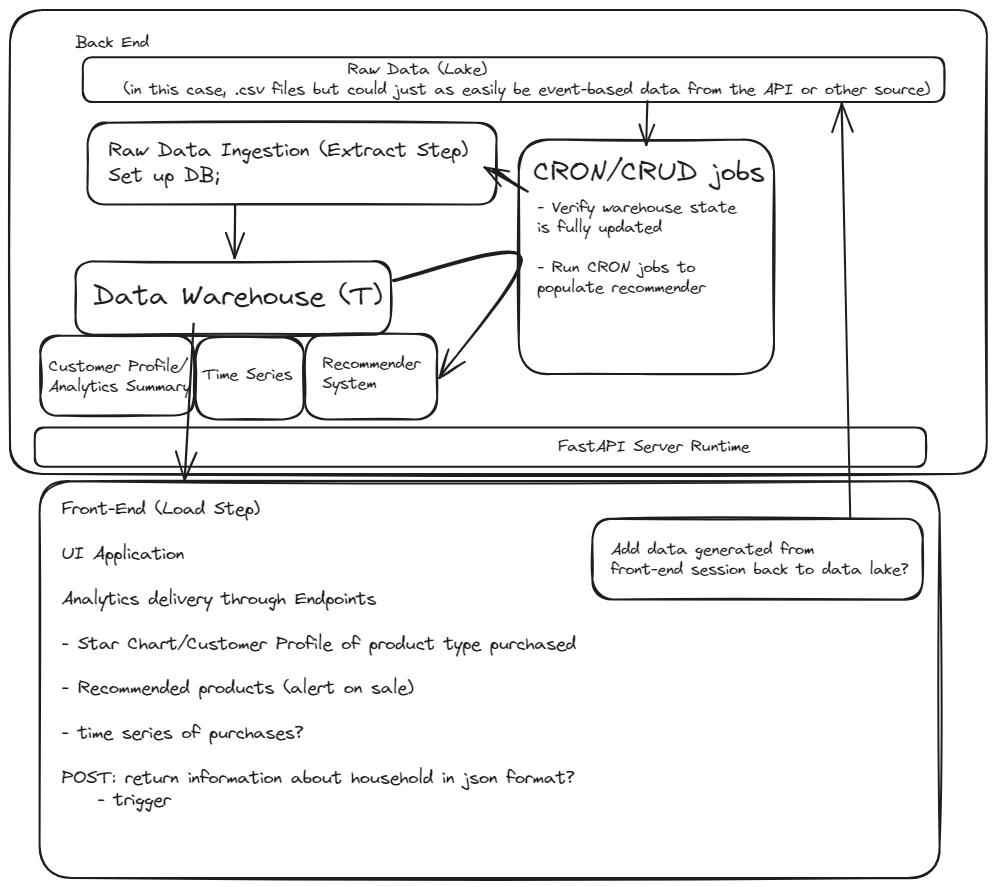

I put together this sketch of how I see the whole system working in 'production'.

I want to focus on the gold tables; 
- customer profile/analytics summary
- recommender system 

to create a basic data warehouse.

before getting started on the Front-end application, which I'm hoping to write in streamlit.

I'm going to run the uvicorn/FastAPI server, and use the API as my 'transaction layer':

Interactions between the data warehouse and the front-end application (Streamlit) will be conducted through the API endpoints to be set up shortly.

#### New Tables

To start, let's get a basic sales summary by household; [over time] and generate the RFM scores which indicate a customer's value to our grocery chain.

These transformations are the product of the EDA done by ~February 2021.

After setting up the data warehouse and API endpoints to fetch the data, we'll implement the recommender system class CRON job to generate a recommendations table based on different metrics, using the RecommenderSystem class .


I'm still getting the hang of the SQLAlchemy ORM syntax, so for my purposes here I'm just going to execute queries directly. The two functions below will make it possible for me to execute queries to the engine.raw_connection. Note that we are working with the engine as defined in the data_lake.py file. 


In [4]:
def clean(query):
    return " ".join(query.replace('\n', ' ').replace('\t', ' ').split())
                    
def query_db(query):
    conn = engine.raw_connection()
    cur = conn.cursor()
    cur.execute(clean(query))
    res = cur.fetchall()
    return res

def return_table(query):
    conn = engine.raw_connection()
    cur = conn.cursor()
    cur.execute(clean(query))
    colnames = [x[0] for x in cur.description]
    res = cur.fetchall()
    return pd.DataFrame(res, columns=colnames)

In [5]:
df1 = return_table("""SELECT round(sum(trans.sales_value),2) as total_sales
         
        FROM transaction_data trans 
         GROUP BY trans.household_key 
         ORDER BY trans.household_key ASC""")

df1['total_sales'].sum()

8057463.079999999

In [6]:



df2 = return_table("""SELECT hhd.household_key
         ,round(sum(trans.sales_value),2) as total_sales
         
        FROM hh_demographic hhd JOIN transaction_data trans 
         ON hhd.household_key = trans.household_key 
         GROUP BY hhd.household_key 
         ORDER BY hhd.household_key ASC""")

# this query takes almost 9 seconds because of the awkward join. We want the results to be available immediately;
# note that by left-joining on the hh_demographic table, we limit the transactions to the 801 hh for which we have data

df2['total_sales'].sum()

4497716.26

In [7]:
query_db(""" select round(sum(sales_value),2) as total_sales from transaction_data""")[0][0]

# good

8057463.08

In [8]:
query_db(""" select round(sum(total_sales),2) as total_sales from hh_summary""")[0][0]


# after gasoline and some other transactions were removed;
# the households for which we have demographic information represent almost half of all sales

3861807.61

In [9]:
df3 = return_table(""" select * from hh_summary""")

In [10]:
df4 = a.get_table('hh_summary')

In [11]:
all(df3 == df4)

True

In [12]:
# see "Customer Analytics Table.ipynb" in the top-level directory

### ANALYTICS DELIVERY USING FASTAPI ()



    note: within the *schemas.py* file we can find schemas, which inherit from 'pydantic.BaseModel'. 
    These are for use with fastAPI, and not to be confused with the SQLAlchemy database abstraction.

    Those pydantic dataclass models define some additional parameters which might be necessary in a development database; for example for specific types of transactions. Account creation information like passwords or emails; or additional, mapped information which might be available in the database already for example previous purchases, or queries from an altogether new database ("gold" data tables).

    These schemas add an additional level of complexity on top of our basic database, but they integrate well with my tech stack, and I believe they offer a significant upside in terms of data accessibility. 
    
    By running some sort of local data API; or automating weekly reports of accounts performance
    an API such as this one could serve a variety of data analytics and reporting use-cases. This automation could save time and money for any company requiring data analytics.


Using FastAPI is easy. In the terminal or shell, from within this /src/ folder, simply run the command `uvicorn main:app --reload`, and a server will begin. 

So far, there is only one endpoint for the API -- but this could easily be upgraded, now that the structure and groundwork has been laid down.

The API currently serves a dictionary of analytics information specific to each household.

Here's an example of the dictionary returned by the api (note the bool values are lowercase, otherwise it's pretty good)


In [ ]:
{"index":0,
# demographic information
"household_key":1,"age_45_plus":true,"income_50K_plus":false,"single_couple_family":2,"has_kids":false,"single":false,"couple":true,
# overall recency/frequency/monetary scores
"r_score":5,"f_score":3,"m_score":4,"rfm_score":12,"rfm_bins":3,
# sales by section
"alcohol":6.48,"beverages":314.83,"concessions":20.33,"dairy":362.76,"drug":53.440000000000005,"garden":0.0,"grain_goods":668.41,
"grocery":230.24,"home_family":537.29,"junk_food":764.02,"kitchen":1.59,"meat":379.04,"misc":303.82,"produce":477.82,"seasonal":0.0,
# total sales value
"total_sales":4120.07}

This information is our back-end 'product' which we serve to the front-end through the API layer.  

In [13]:
a.get_table('hh_summary').columns

Index(['index', 'household_key', 'age_45_plus', 'income_50K_plus',
       'single_couple_family', 'has_kids', 'single', 'couple', 'R', 'F', 'M',
       'RFM', 'RFM Bins', 'alcohol', 'beverages', 'concessions', 'dairy',
       'drug', 'garden', 'grain_goods', 'grocery', 'home_family', 'junk_food',
       'kitchen', 'meat', 'misc', 'produce', 'seasonal', 'total_sales'],
      dtype='object')